['If Abode mode changed to home, then dim front lights to 1% Create a group in '
 'Wink off all the lights you would like dimmedThe create a shortcut and set '
 'the brightness level Activate shortcut']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['if', 'abode', 'mode', 'changed', 'to', 'home', 'then', 'dim', 'front', 'lights', 'to', 'create', 'group', 'in', 'wink', 'off', 'all', 'the', 'lights', 'you', 'would', 'like', 'dimmedthe', 'create', 'shortcut', 'and', 'set', 'the', 'brightness', 'level', 'activate', 'shortcut']]
[['change', 'home', 'dim', 'front', 'light', 'create', 'group', 'wink', 'light', 'would_like', 'create', 'shortcut', 'set', 'brightness', 'level', 'activate', 'shortcut']]

Coherence Score:  0.6114549990049438


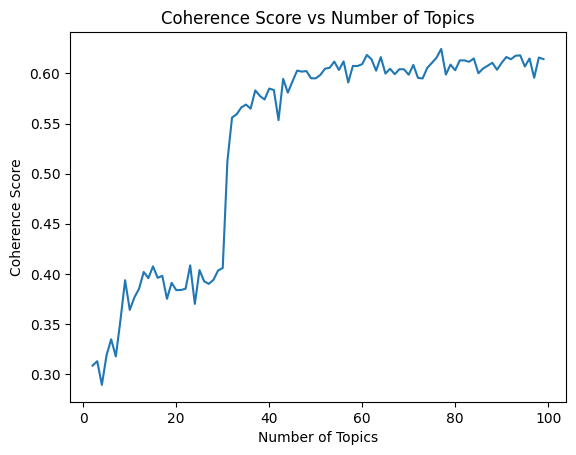

Optimal number of topics: 77
Highest Coherence Score: 0.6244678811176841
Optimal number of topics (elbow method): 3
Coherence Score at optimal topics: 0.3127402983394836

Topics for optimal number of topics (3):
Topic 0: 0.1644106507*"turn" + 0.1353663355*"light" + 0.0442545004*"home" + 0.0335284099*"switch" + 0.0296556465*"leave" + 0.0233145449*"hue" + 0.0230871737*"change" + 0.0180970561*"color" + 0.0144397132*"wemo" + 0.0136433793*"detect"
Topic 1: 0.0476179682*"send" + 0.0339128487*"location" + 0.0249246210*"notification" + 0.0241394918*"get" + 0.0208554938*"area" + 0.0185868032*"add" + 0.0180854574*"home" + 0.0180518609*"text" + 0.0172667224*"enter" + 0.0154851340*"time"
Topic 2: 0.0661006570*"set" + 0.0408228301*"temperature" + 0.0310736746*"phone" + 0.0260273572*"blink" + 0.0242953189*"nest" + 0.0205277745*"toggle" + 0.0143477079*"call" + 0.0139072062*"use" + 0.0135554075*"event" + 0.0130378641*"know"

Saving topics for optimal number of topics (3) to CSV...
Topics saved to opti

In [ ]:
import pandas as pd
import numpy as np
import string
import re
from pprint import pprint
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt
import logging
import warnings
import csv

# Enable logging for error tracking during model training and execution
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load the dataset from CSV file
df = pd.read_csv('LabeledDataset_target_2.csv', sep=',')

# Concatenate specified columns ('title', 'desc', 'actionTitle') into a single text string for each row
# This will be used as the input for topic modeling
data = df[['title', 'desc', 'actionTitle']].astype(str).agg(' '.join, axis=1).values.tolist()
pprint(data[:1])

# Download the NLTK stopwords dataset (words like "the", "and", etc. which will be removed from the text)
nltk.download('stopwords')

# Function to convert a list of sentences to a list of tokenized words (using gensim's simple_preprocess)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Apply the function to convert the data into a list of words
data_words = list(sent_to_words(data))
print(data_words[:1])

# Build the bigram model using gensim
# A bigram is a sequence of two adjacent words
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)# Create a fast model for bigrams


# Define the list of stopwords (common words to exclude in text analysis)
stop_words = stopwords.words('english')

# Function to remove stopwords from the tokenized text
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Function to create bigrams in the tokenized text
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


# Apply the functions to remove stopwords and generate bigrams
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spaCy for lemmatization (reducing words to their base form, like "running" to "run")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function for lemmatization based on specified POS tags (NOUN, ADJ, VERB, ADV)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) # Process each sentence
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Apply lemmatization to the text data
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])


# Create a Dictionary and Corpus for the LDA model
# Dictionary maps word IDs to words, and Corpus stores the word frequency for each document
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized] # Bag of words for each document

# Build the LDA model to discover topics in the dataset
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=100,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=4,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute and display the coherence score of the LDA model to evaluate topic quality
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Function to compute coherence score for different numbers of topics
# This helps to find the optimal number of topics for the dataset
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=4,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Run the model for different numbers of topics and calculate the coherence scores
start = 2  # Minimum number of topics
limit = 100  # Maximum number of topics (adjusted for a more reasonable range)
step = 1  # Step size (can be adjusted)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

# Plot coherence score vs number of topics to visualize the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Print the number of topics with the highest coherence score
max_coherence_value = max(coherence_values)
optimal_topic_num = start + coherence_values.index(max_coherence_value)
print(f"Optimal number of topics: {optimal_topic_num}")
print(f"Highest Coherence Score: {max_coherence_value}")

# Function to compute the second derivative and find the elbow point in the coherence values
# This method helps identify the "elbow" where increasing topics does not significantly improve the model
def find_elbow_point(coherence_values):
    first_derivative = np.diff(coherence_values)
    second_derivative = np.diff(first_derivative)
    elbow_index = np.argmax(second_derivative < 0) + 1  # +1 to account for the diff
    return elbow_index

# Find and print the optimal number of topics using the elbow method
elbow_index = find_elbow_point(coherence_values)
elbow_topic_num = elbow_index + start  # Adjust elbow index to get the correct topic number
if elbow_topic_num < limit:
    elbow_coherence_value = coherence_values[elbow_index]
else:
    elbow_coherence_value = None

print(f"Optimal number of topics (elbow method): {elbow_topic_num}")
if elbow_coherence_value is not None:
    print(f"Coherence Score at optimal topics: {elbow_coherence_value}")

# Function to print topics with increased decimal places
def print_lda_topics(model, num_topics=3, decimals=10):
    topics = model.print_topics(num_topics=num_topics)
    for topic in topics:
        topic_id = topic[0]
        topic_words = topic[1]
        # Format the topic string to show more decimal places
        formatted_topic = " + ".join([f"{weight:.{decimals}f}*\"{word}\"" for word, weight in model.show_topic(topic_id)])
        print(f"Topic {topic_id}: {formatted_topic}")

# Print the topics for the optimal number of topics
if elbow_topic_num < limit:
    optimal_model = model_list[elbow_index]
    print(f"\nTopics for optimal number of topics ({elbow_topic_num}):")
    print_lda_topics(optimal_model, num_topics=elbow_topic_num)


# Function to save the optimal topics and their details into a CSV file
def save_elbow_output_to_csv(model, num_topics, file_name="elbow_topics.csv"):
    # Get the topics and word scores
    topic_info = []
    for i in range(num_topics):
        topic_keywords = model.show_topic(i)  # Get the top words for this topic
        words = [word for word, score in topic_keywords]  # Extract words
        scores = [score for word, score in topic_keywords]  # Extract word scores
        topic_score = sum(scores) / len(scores)  # Calculate average topic score (for example)

        # Store the topic information in the required format
        topic_info.append({
            'Topic Number': i + 1,
            'Keywords': ", ".join(words),  # Join keywords as a single string
            'Scores': scores,  # List of word scores
            'Topic Score': topic_score  # Average score for this topic
        })

    # Save the topic information to a CSV file
    with open(file_name, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Topic Number', 'Keywords', 'Scores', 'Topic Score'])
        writer.writeheader()
        for topic in topic_info:
            writer.writerow(topic)

    print(f"Topics saved to {file_name} successfully!")

# Call the function to save the elbow output in CSV
if elbow_topic_num < limit:
    optimal_model = model_list[elbow_index]
    print(f"\nSaving topics for optimal number of topics ({elbow_topic_num}) to CSV...")
    save_elbow_output_to_csv(optimal_model, num_topics=elbow_topic_num, file_name="optimal_elbow_topics_2.csv")

**Extracting Different Numbers of Topics based on The Elbow Methond**

In [ ]:
import numpy as np
import csv

# Function to compute the second derivative and find the elbow point
def find_elbow_point(coherence_values):
    first_derivative = np.diff(coherence_values)  # Calculate the first derivative (rate of change)
    second_derivative = np.diff(first_derivative)  # Calculate the second derivative (acceleration of change)
    elbow_index = np.argmax(second_derivative < 0) + 1  # Find the index where the second derivative first becomes negative
    return elbow_index

# Find and print the optimal number of topics using the elbow method
elbow_index = find_elbow_point(coherence_values)
elbow_topic_num = elbow_index + start  # Adjust elbow index to get the correct topic number
elbow_coherence_value = coherence_values[elbow_index] if elbow_topic_num < limit else None

print(f"Optimal number of topics (elbow method): {elbow_topic_num}")
if elbow_coherence_value is not None:
    print(f"Coherence Score at optimal topics (elbow method): {elbow_coherence_value}")

# Use the model selected by the elbow method (but override to 20 topics)
num_topics_to_save = 40

# Function to save the output of 20 topics in a CSV file
def save_elbow_output_to_csv(model, num_topics, file_name="elbow_method_20_topics.csv"):
    # Get the topics and word scores
    topic_info = []
    for i in range(num_topics):
        topic_keywords = model.show_topic(i)  # Get the top words for this topic
        words = [word for word, score in topic_keywords]  # Extract words
        scores = [score for word, score in topic_keywords]  # Extract word scores
        topic_score = sum(scores) / len(scores)  # Calculate average topic score (for example)

        # Store the topic information in the required format
        topic_info.append({
            'Topic Number': i + 1,
            'Keywords': ", ".join(words),  # Join keywords as a single string
            'Scores': scores,  # List of word scores
            'Topic Score': topic_score  # Average score for this topic
        })

    # Save the topic information to a CSV file
    with open(file_name, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Topic Number', 'Keywords', 'Scores', 'Topic Score'])
        writer.writeheader()
        for topic in topic_info:
            writer.writerow(topic)

    print(f"Topics saved to {file_name} successfully!")

# Call the function to save 20 topics to CSV
if num_topics_to_save <= limit:
    optimal_model = model_list[num_topics_to_save - 1]  # Using 20 topics regardless of elbow
    print(f"\nSaving topics for 20 topics to CSV...")
    save_elbow_output_to_csv(optimal_model, num_topics=num_topics_to_save, file_name="optimal_elbow_40_topics_2.csv")

Optimal number of topics (elbow method): 3
Coherence Score at optimal topics (elbow method): 0.3127402983394836

Saving topics for 20 topics to CSV...
Topics saved to optimal_elbow_40_topics_2.csv successfully!
